## Polygons, Multipolygons, and Handling Holes

### Introduction

In geospatial analysis, working with complex polygon geometries—such as those with multiple rings (multipolygons) or holes—requires a solid understanding of how to define, manipulate, and analyze these shapes. Whether you're defining a region of interest over a body of water, a forested area, or any other feature, correctly handling these geometries is crucial for accurate analysis, particularly when working with satellite imagery or other raster data.

### Objective

The objective of this tutorial is to teach you how to handle complex polygon geometries, including multipolygons and polygons with holes, and to use these geometries in a geospatial analysis workflow. We will demonstrate how to visualize these geometries, properly configure them for use with geospatial tools, and fetch satellite imagery data that corresponds to the defined regions.

### In this notebook, you will explore the following concepts:

- **Complex Geometries**: Understanding how to represent and work with advanced geometric shapes like multipolygons and polygons with holes. These geometries are essential when analyzing regions that are not simply defined by a single, contiguous area.

- **GeoJSON and Shapely**: GeoJSON is a common format for encoding geographic data structures, while Shapely is a Python library used for manipulation and analysis of these structures. Both are critical for defining and managing complex geometries in a spatial analysis workflow.

- **Time Series Analysis in OpenEO**: Understanding how to manage and validate time series data when polygons with holes are used. This involves ensuring that spatial extents are correctly interpreted over time, particularly when some regions are marked as no-data due to the presence of holes in the geometry.

### Tools You'll Use:

- **OpenEO**: To interact with satellite data and perform spatial operations.
- **GeoPandas**: For managing geospatial data, particularly complex geometries like multipolygons and polygons with holes.
- **Shapely**: For advanced geometric operations and ensuring the correct structure of your geometries.
- **Matplotlib**: For visualizing the geometries and results of your analysis.

### Learning Outcomes:

By the end of this tutorial, you will be able to:

- Define and manipulate complex polygon geometries, including those with holes and multiple components.
- Visualize and validate these geometries using GeoPandas.
- Fetch and analyze satellite imagery data corresponding to these complex geometries using OpenEO.
- Understand the importance of correctly defining geometries in geospatial analysis to ensure accurate results.

### Let's Begin:

We'll start by importing some common Python modules and creating a connection to the OpenEO backend. Then, we’ll proceed to create and visualize complex polygon geometries before using these geometries in our geospatial analysis workflow.


In [1]:
import openeo
import io
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import json

from shapely.geometry import shape, Polygon

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

from pyproj import Transformer

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from config import user,passwd,eo_service_url
from demo_helpers import show_result
from demo_regions import s2

plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
# Connect to OpenEO
conn = openeo.connect(eo_service_url)

conn.authenticate_basic(username=user, password=passwd)
#conn.authenticate_oidc()

<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

### A. Creating and Visualizing Complex Geometries

#### A Polygon over Lake Mälaren with Holes

When working with polygon geometries, particularly those with holes, it’s crucial to correctly structure these geometries to ensure they are interpreted accurately by geospatial tools. One common scenario arises when using the GeoJSON editor available in the OpenEO web editor.

#### Understanding the GeoJSON Structure from the OpenEO Web Editor

When you draw a polygon with holes in the OpenEO web editor, the resulting GeoJSON structure typically outputs each part of the polygon as separate features. Specifically, the outer polygon and the holes are treated as separate entities, placed "aside" from each other in the GeoJSON. However, for correct geospatial analysis, these parts need to be combined into a single polygon structure where the outer boundary is defined first, followed by the holes.

In GeoJSON, a polygon with holes is represented by an array of coordinate arrays:
- The **first array** represents the outer boundary of the polygon (which should be defined counterclockwise).
- The **subsequent arrays** represent the holes within that polygon (which should be defined clockwise).

This step is critical because improperly structured polygons can lead to incorrect results in spatial operations, such as area calculations or when fetching satellite imagery data.

In this section, we will:
1. **Examine the Output from the GeoJSON Editor**: We’ll start by reviewing the structure of the GeoJSON output where the holes are treated as separate features.
2. **Correct the Structure**: We’ll move the hole polygons "inside" the main polygon, creating a valid GeoJSON structure with a single polygon that includes holes.


In [3]:
three_polys_from_geojson_editor = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature", "geometry": {"type": "Polygon",
        "coordinates": [ [(16.514, 59.616), (16.436, 59.571), (16.444, 59.527), (16.493, 59.506), (16.684, 59.499), (16.825, 59.493), (16.892, 59.525), (16.901, 59.621), (16.514, 59.616)]]
      },
      "properties": None
    },
    {
      "type": "Feature", "geometry": {"type": "Polygon",
        "coordinates": [ [(16.552, 59.583), (16.49, 59.578), (16.495, 59.545), (16.574, 59.559), (16.552, 59.583)]]
      },
      "properties": None
    },
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [[(16.82, 59.55), (16.727, 59.55), (16.727, 59.586), (16.82, 59.586), (16.82, 59.55)]]
      },
      "properties": None
    }
  ]
} 
# Move the hole polygons inside to create the holes
proper_poly_with_hole={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature", "geometry": {"type": "Polygon",
        "coordinates": [  
                        [(16.514, 59.616), (16.436, 59.571), (16.444, 59.527), (16.493, 59.506), (16.684, 59.499), (16.825, 59.493), (16.892, 59.525), (16.901, 59.621), (16.514, 59.616)],
                        [(16.552, 59.583), (16.49, 59.578), (16.495, 59.545), (16.574, 59.559), (16.552, 59.583)],
                        [(16.82, 59.55), (16.727, 59.55), (16.727, 59.586), (16.82, 59.586), (16.82, 59.55)]

                       ]
      },
      "properties": None
    },
  ]
} 

### B. Using GeoPandas for Spatial Operations

#### 1. Visualize the Geometry

Now that we have corrected the GeoJSON structure by moving the holes inside the outer polygon, it’s important to visualize the geometry to confirm that the modifications have been applied correctly. 

Using GeoPandas, we can easily visualize the polygon with its holes. This step is crucial to ensure that the polygon is accurately represented before we use it in further spatial operations or when fetching satellite imagery data.

Let's proceed with the visualization:

In [4]:
print("From GeoJSON editor:")
display(gpd.GeoDataFrame.from_features(three_polys_from_geojson_editor))
print("Moved holes inside the polygon")
display(gpd.GeoDataFrame.from_features(proper_poly_with_hole))

From GeoJSON editor:


,geometry
0,"POLYGON ((16.51400 59.61600, 16.43600 59.57100..."
1,"POLYGON ((16.55200 59.58300, 16.49000 59.57800..."
2,"POLYGON ((16.82000 59.55000, 16.72700 59.55000..."


Moved holes inside the polygon


,geometry
0,"POLYGON ((16.51400 59.61600, 16.43600 59.57100..."


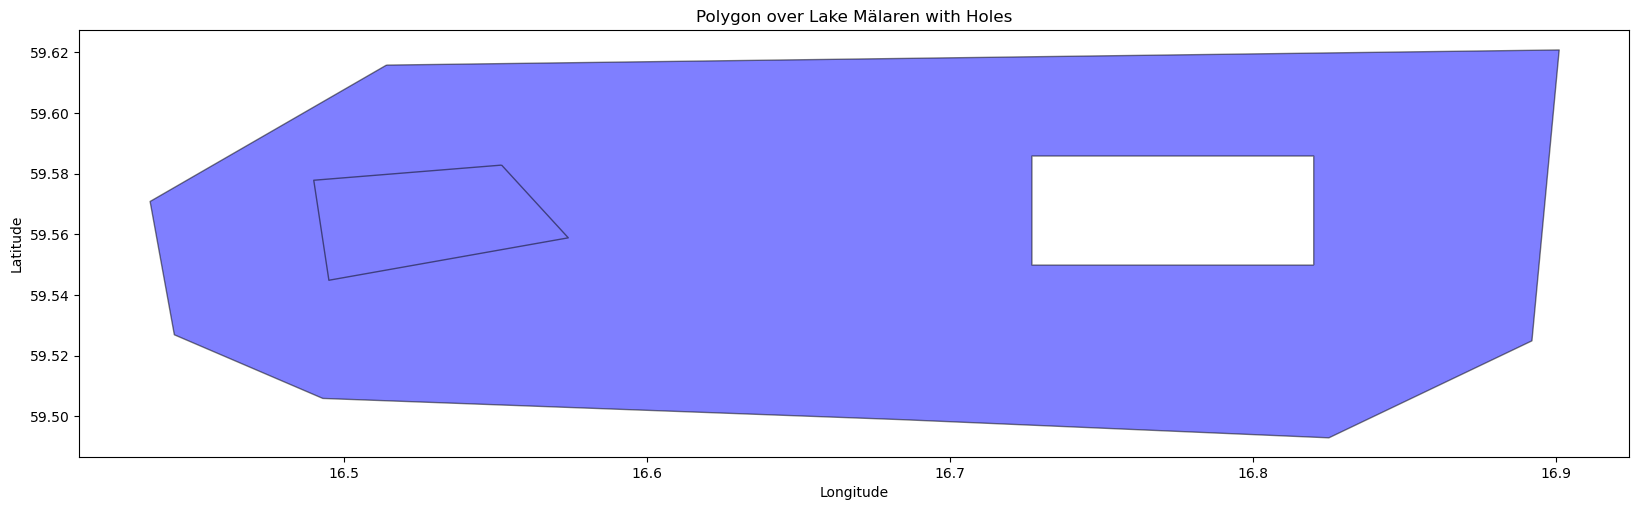

In [5]:
# Choose the corrected polygon structure for visualization
poly = proper_poly_with_hole
#poly = three_polys_from_geojson_editor  # Uncomment to see the uncorrected structure

# Convert the GeoJSON to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(poly)

# Create a plot to visualize the geometry
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Polygon over Lake Mälaren with Holes')

plt.show()

While the visualization might not always perfectly reflect the geometry due to limitations in the plotting library, the underlying structure of the polygon is correct. Despite these minor discrepancies in visualization, the polygon is properly defined and can be confidently used for further analysis. Let's proceed with fetching satellite imagery using this geometry!

# C. Fetching Satellite Imagery with OpenEO:
Once our geometries are properly defined and structured, the next step is to fetch corresponding satellite imagery using OpenEO. This step is crucial for validating that the polygons, including any holes, are accurately represented in the imagery. This is particularly important when analyzing specific areas, such as regions of interest over bodies of water or land where certain areas need to be excluded from analysis.

In this section, we will:

1. **Use the Polygon with Holes to Fetch Imagery**: We will use the properly structured polygon with holes to retrieve satellite imagery, ensuring that the holes are correctly rendered as no-data regions in the image.
2. **Visualize the Fetched Imagery**: By visualizing the resulting image, we will confirm that the holes in our polygon are correctly reflected as areas with no data in the satellite imagery.

Here’s how we proceed:

[<open DatasetReader name='/vsipythonfilelike/52cf7d15-86a5-4cb8-a5e3-3fc11abfc452/52cf7d15-86a5-4cb8-a5e3-3fc11abfc452' mode='r'>]

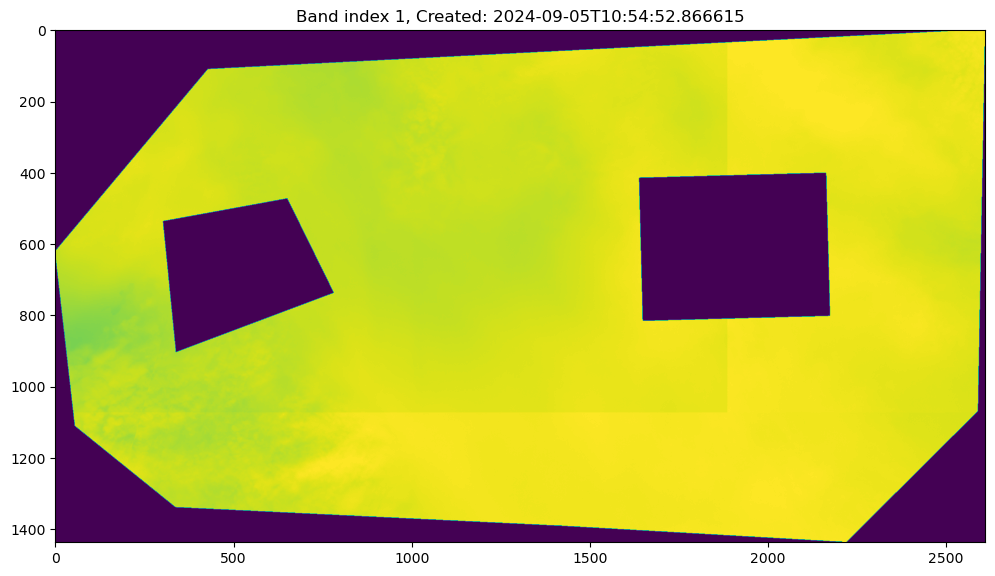

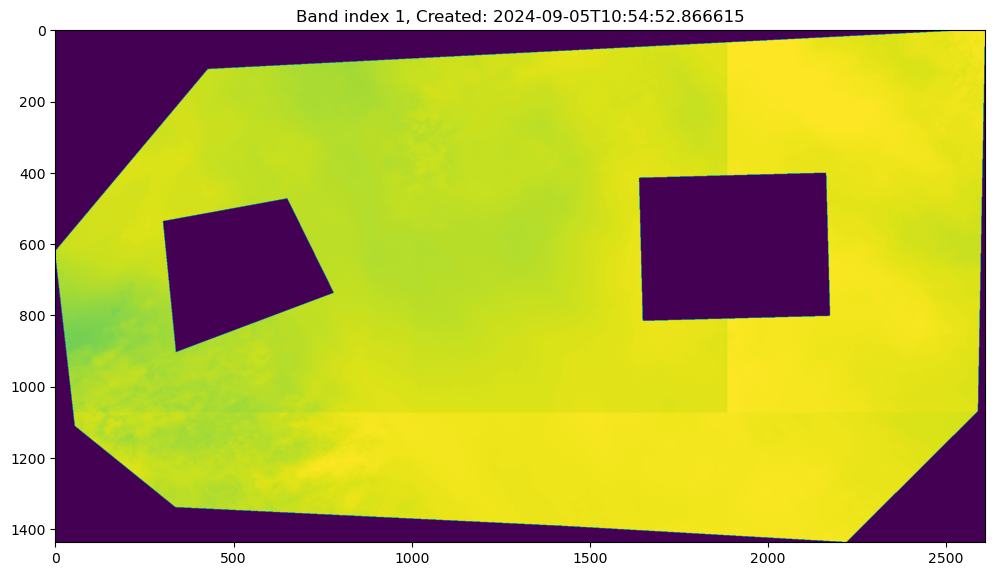

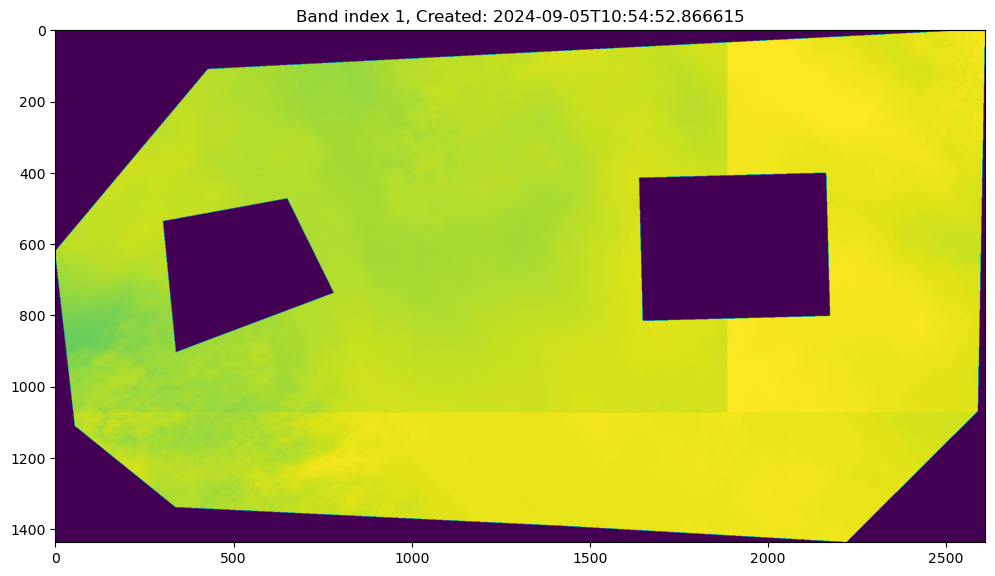

In [6]:
# Download S2MSI2A data
cube = conn.load_collection(
    s2.s2_msi_l2a,
    bands=["b04", "b03", "b02"],  # RGB channels
    spatial_extent=poly,
    temporal_extent=["2022-06-01", "2022-06-05"],
)

# Reduce the dimension over time by selecting the first image in the time range
cube = cube.reduce_dimension(dimension="t", reducer="first")

# Download the resulting image in GeoTIFF format
s2_image_data2 = cube.download(format="gtiff")

# Visualize the fetched image to check how the holes are represented
show_result(s2_image_data2)


# Demonstrating Time Series Cutouts with Holes in Satellite Imagery

In this final section, we will demonstrate how OpenEO handles time series data when polygons with holes are used as the spatial extent. Specifically, we will show that even when we request a time series of images, each time step is correctly "cut out" according to the geometry of the polygon, including the holes.

This ensures that the holes are respected across all time steps, providing consistent and accurate data for time series analysis.
Steps:

1. **Requesting a Time Series of Images**: We will fetch a series of images over a specified date range. The geometry used (including the holes) will be applied consistently across all time steps.
2. **Visualizing the Time Series**: We will visualize each time step to confirm that the holes are correctly represented as no-data regions across all the images.

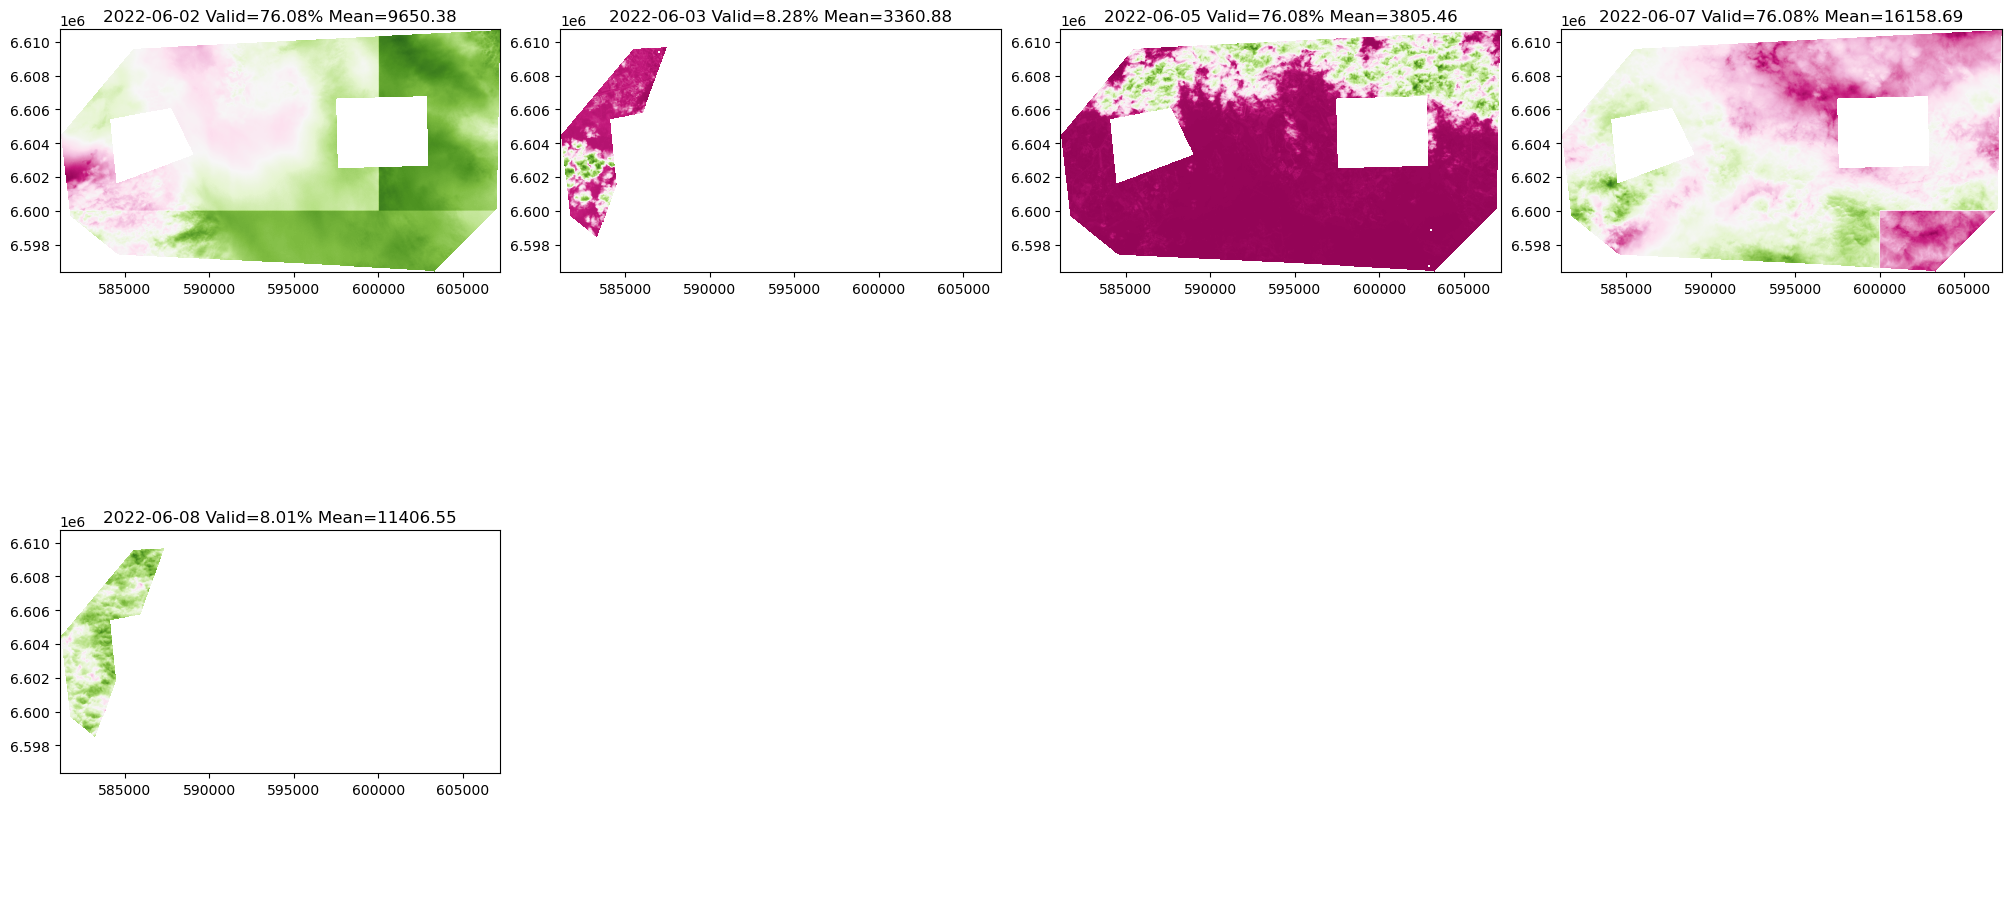

In [8]:
from datetime import datetime
fname = f"img_{datetime.now().isoformat()}.nc"  # needs to be different each time, see explanation further down in the notebook

# Request a time series of Sentinel-2 images
cube = conn.load_collection(
    s2.s2_msi_l2a,
    bands=["b04", "b03", "b02"],  # RGB channels
    spatial_extent=poly,
    temporal_extent=["2022-06-01", "2022-06-10"],
)

# Download the resulting time series as a NetCDF file
res = cube.download(outputfile=fname, format="netcdf")

# Load the data into an xarray dataset for further analysis
loaded_data = xr.open_dataset(fname, engine='h5netcdf', decode_times=True)

# Handle no-data values
nodata = loaded_data.attrs.get("nodata", None)
loaded_data = loaded_data.where(loaded_data != nodata, np.nan)

# Import helper functions for plotting
from demo_helpers import plot_xr_dataarray_contact_copy, plot_xr_dataarray_on_map

# Visualize one of the bands ('b02') across the time series
plot_xr_dataarray_contact_copy(loaded_data['b02'], figsize=(20,10), cmap="PiYG")


As shown in the visual output, each time step in the series respects the geometry of the polygon, including the holes. This consistency is crucial for accurate temporal analysis, as it ensures that no data is included from regions outside the intended area of interest, such as water bodies or other excluded areas.

This final step verifies that OpenEO correctly handles complex geometries in time series requests, providing reliable data for further analysis, such as monitoring changes over time or performing land cover classification.

# A note about the unique filename:
When working with file-based datasets, such as those loaded with GDAL or xarray, it's often necessary to use a different filename each time you download or generate new data, especially when you're working within the same session or repeatedly loading data into memory. This is because these libraries (GDAL, xarray, etc.) sometimes cache data in memory or on disk to improve performance. If you attempt to reload data using the same filename, the library might not actually reload the file from disk but instead return a cached version of the data.

This behavior can lead to issues where changes in the dataset (such as different time steps or new spatial extents) are not reflected in your analysis because the library is still using the old cached data. By using a different filename each time, you effectively force the library to reload the entire dataset from scratch, ensuring that the most recent data is used in your analysis.

In our case, we're assigning a unique filename ("img_todays_date.nc") for each download to avoid potential caching issues. This practice ensures that we always work with the latest version of the data, which is critical when analyzing time series data or when making iterative adjustments to our data processing workflow.